In [1]:
!pip install -U torch==1.8.0 torchtext==0.9.0
exit()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))

In [2]:
pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 853.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.8.0
    Uninstalling torch-1.8.0:
      Successfully uninstalled torch-1.8.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.1+cu118
    Uninstalling torchvision-0.15.1+cu118:
      Successfully uninstalled torchvision-0.15.1+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.1+cu118
    Uninstalling torchaudio-2.0.1+cu118:
      Successfully uninstalled torchaudio-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into acc

In [3]:
import torch
import json
from torchtext.legacy import data
import torch.nn as nn
import torch.optim as optim
import time
from torch.nn import Embedding

import random
import math

import matplotlib.pyplot as plt

In [4]:
! pip install datasets transformers > /dev/null

In [5]:
from datasets import load_dataset
squad_v2 = False
model_checkpoint = "bert-large-uncased-whole-word-masking-finetuned-squad"
batch_size = 32
dataset2 = load_dataset("squad_v2" if squad_v2 else "squad")

  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
dataset2['train'][0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

In [7]:
ans1 = dataset2['train']['answers']
print(type(ans1))

<class 'list'>


In [8]:
ans1[1]['text'][0]

'a copper statue of Christ'

In [14]:
def get_examples_hotpot(file):
    ak = json.load(open(file))
    examples = []
    for j, i in enumerate(ak):
        # Limiting examples coz ram not sufficient. find another way..some sort of yield
        if len(examples) > 30000:
          break
        context = "".join([k for j in i['context'] for k in j[1]])
        question = i['question']
        answer= i['answer']
        examples.append([context + question_pad + question, answer])
    return examples


In [15]:
def get_examples_squad(file):
  examples=[]
  for i in dataset2[file]:
    context=i['context']
    question=i['question']
    ans2=i['answers']
    answer=ans2['text'][0]
    examples.append([context, question, answer])
  return examples

In [16]:
def get_data(train_file1, validation_file1, train_file, validation_file):
    train_examples = get_examples_hotpot(train_file1)
    validation_examples = get_examples_hotpot(validation_file1)
    train_examples.append(get_examples_squad(train_file))
    validation_examples.append(get_examples_squad(validation_file))

    context_with_question = data.Field(sequential = True, tokenize = 'spacy', init_token = '<sos>', eos_token = '<eos>')
    answer = data.Field(sequential = True, tokenize = 'spacy', init_token = '<sos>', eos_token = '<eos>')
    fields = [('context', context_with_question), ('answer', answer)]
    train_Examples = [data.Example.fromlist([i[0], i[1]], fields) for i in train_examples]
    train_dataset = data.Dataset(train_Examples, fields)

    validation_Examples = [data.Example.fromlist([i[0], i[1]], fields) for i in validation_examples]
    validation_dataset = data.Dataset(validation_Examples, fields)

    context_with_question.build_vocab(train_dataset, min_freq = 2, max_size = 30000,vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)
    answer.vocab = context_with_question.vocab
    return context_with_question, answer, train_dataset, validation_dataset


In [17]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(input_dim, emb_dim)  # no dropout as only one layer!
        self.rnn = nn.GRU(emb_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)  # no cell state!
        return hidden

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)
        self.fc_out = nn.Linear(emb_dim + hid_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, context):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        emb_con = torch.cat((embedded, context), dim=2)
        output, hidden = self.rnn(emb_con, hidden)
        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)),
                           dim=1)
        prediction = self.fc_out(output)
        return prediction, hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert encoder.hid_dim == decoder.hid_dim, "Hidden dimensions of encoder and decoder must be equal!"

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        context = self.encoder(src)
        hidden = context
        input = trg[0, :]
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, context)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

def init_weights(m):
    for name, param in m.named_parameters():
        if not isinstance(m, Embedding):
            nn.init.normal_(param.data, mean=0, std=0.01)

def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src = batch.context
        trg = batch.answer
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.context
            trg = batch.answer
            output = model(src, trg, 0)  # turn off teacher forcing
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def model_training(epochs):
    best_valid_loss = float('inf')
    for epoch in range(epochs):
        start_time = time.time()
        train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
        valid_loss = evaluate(model, test_iterator, criterion)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'tut2-model.pt')

        train_loss_PPL = math.exp(train_loss)
        valid_loss_PPL = math.exp(valid_loss)
        print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_loss_PPL:7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {valid_loss_PPL:7.3f}')

        return train_loss, valid_loss, train_loss_PPL, valid_loss_PPL

Epoch: 01 | Time: 2m 24s
	Train Loss: 6.075 | Train PPL: 434.891
	 Val. Loss: 5.875 |  Val. PPL: 355.933
Epoch: 01 | Time: 2m 20s
	Train Loss: 5.264 | Train PPL: 193.215
	 Val. Loss: 5.837 |  Val. PPL: 342.884
Epoch: 01 | Time: 2m 20s
	Train Loss: 5.052 | Train PPL: 156.368
	 Val. Loss: 5.814 |  Val. PPL: 334.905
Epoch: 01 | Time: 2m 22s
	Train Loss: 4.877 | Train PPL: 131.201
	 Val. Loss: 5.834 |  Val. PPL: 341.602
Epoch: 01 | Time: 2m 21s
	Train Loss: 4.682 | Train PPL: 107.957
	 Val. Loss: 5.786 |  Val. PPL: 325.780


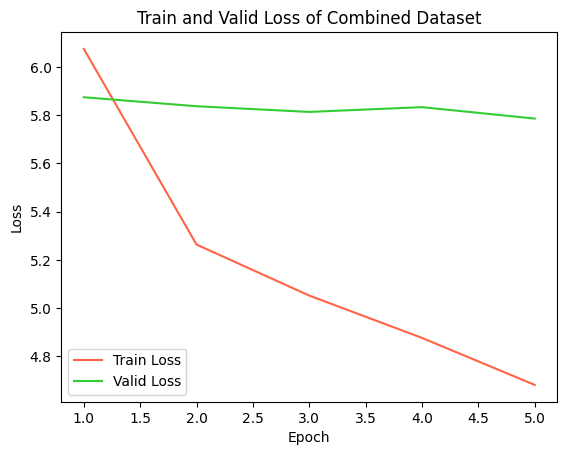

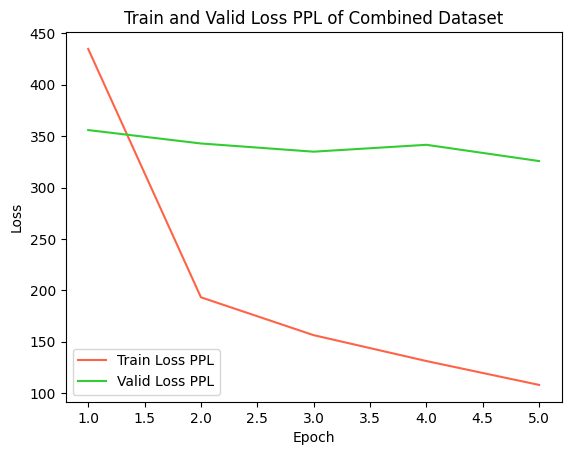

In [18]:
if __name__ == "__main__":
    question_pad = ' @qpad '

    BATCH_SIZE = 128
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_file = "train"
    validation_file = "validation"

    train_file1= "data/hotpot_train_v1.1.json"
    validation_file1="data/hotpot_dev_fullwiki_v1.json"

    context_with_question, answer, train_dataset, validation_dataset = get_data(train_file1, validation_file1, train_file, validation_file)
    #context_with_question_sq, answer_sq, train_dataset_sq, validation_dataset_sq = get_data_squad(train_file, validation_file)
    
    #context_with_question.append(context_with_question_sq)
    #answer.append(answer_sq)
    #train_dataset.append(train_dataset_sq)
    #validation_dataset.append(validation_dataset_sq)

    train_iterator, test_iterator = data.BucketIterator.splits(
        (train_dataset, validation_dataset), batch_size = BATCH_SIZE,
        sort_key = lambda x: len(x.context), sort_within_batch = True, device = device)

    INPUT_DIM = len(context_with_question.vocab)
    OUTPUT_DIM = len(context_with_question.vocab)
    ENC_EMB_DIM = 100
    DEC_EMB_DIM = 100
    HID_DIM = 200
    ENC_DROPOUT = 0.5
    DEC_DROPOUT = 0.5

    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT)
    dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_DROPOUT)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Seq2Seq(enc, dec, device).to(device)
    model.apply(init_weights)
    optimizer = optim.Adam(model.parameters())
    TRG_PAD_IDX = answer.vocab.stoi[answer.pad_token]
    criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

    epochs = 5
    CLIP = 1

    train_loss_list = []
    valid_loss_list = []
    train_loss_PPL_list = []
    valid_loss_PPL_list = []
    epoch_list = [i for i in range(1, epochs + 1)]

    for epoch in range(epochs):
        train_loss, valid_loss, train_loss_PPL, valid_loss_PPL = model_training(epochs)

        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        train_loss_PPL_list.append(train_loss_PPL)
        valid_loss_PPL_list.append(valid_loss_PPL)

    # Training & Testing Accuracy Plot
    plt.plot(epoch_list, train_loss_list, color = 'tomato', label = 'Train Loss')
    plt.plot(epoch_list, valid_loss_list, color = 'limegreen', label = 'Valid Loss')
    plt.legend(loc = 'lower left')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Valid Loss of Combined Dataset')
    plt.show()

    # Training & Testing Loss Plot
    plt.plot(epoch_list, train_loss_PPL_list, color = 'tomato', label = 'Train Loss PPL')
    plt.plot(epoch_list, valid_loss_PPL_list, color = 'limegreen', label = 'Valid Loss PPL')
    plt.legend(loc = 'lower left')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Valid Loss PPL of Combined Dataset')
    plt.show()